# Определение перспективного тарифа для телеком-компании

Оператор связи решил оценить, какой тарифный план приносит большую прибыль.

У нас имеется выборка данных для пользователей оператора по использованию двух тарифных планов «Смарт» и «Ультра», проанализируем их поведение и попробуем сделать выводы по более перспективному тарифу для компании.

**Описание тарифов**

*Тариф «Смарт»*
1. Ежемесячная плата: 550 рублей
2. Включено в пакет:
    - разговоры: 500 минут
    - сообщения: 50
    - интернет-трафик: 15 Гб
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*
1. Ежемесячная плата: 1950 рублей
2. Включено в пакет:
    - разговоры: 3000 минут
    - сообщения: 1000
    - интернет-трафик: 30 Гб
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

Значения минут и мегабайтов округляется вверх. Если пользователь проговорил 1 секунду, засчитывается 1 минута.

## Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Тип данных *call_date* нужно преобразовать к типу datetime.

In [4]:
internet = pd.read_csv('datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Тип данных *session_date* нужно преобразовать к типу datetime. 
Столбец *Unnamed: 0* нужно удалить

In [6]:
messages = pd.read_csv('datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Тип данных *message_date* нужно преобразовать к типу datetime. 

In [8]:
tariffs = pd.read_csv('datasets/tariffs.csv')
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [9]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [10]:
users = pd.read_csv('datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Тип данных *churn_date*, *reg_date* нужно преобразовать к типу datetime. Есть нулы, но они нам не должны мешать, так как это признак, который нам возможно потребуется использовать

### Вывод

Предварительная оценка данных показывает, что требуется преобразовать тип некоторых столбцов к дате, удалить один ненужный столбец. Нет столбцов с пропущенными значениями, которые требуется анализировать.

## Подготовка данных

### Таблица internet (информация об интернет-сессиях)

In [12]:
internet = internet.drop(labels='Unnamed: 0', axis=1)

In [13]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [14]:
internet['session_date'].describe()

count         149396
unique           365
top       2018-12-31
freq            1057
Name: session_date, dtype: object

Можем предположить, что здесь везде даты, и их 365 разных по количеству дней в году. Изменение тип поля на дату не должно быть проблематичным. Отметим, что больше всего данных по использованию интернета накануне нового года 31 декабря.

In [15]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [16]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [17]:
internet.duplicated().sum()

0

Общих повторений по всем столбцам нету

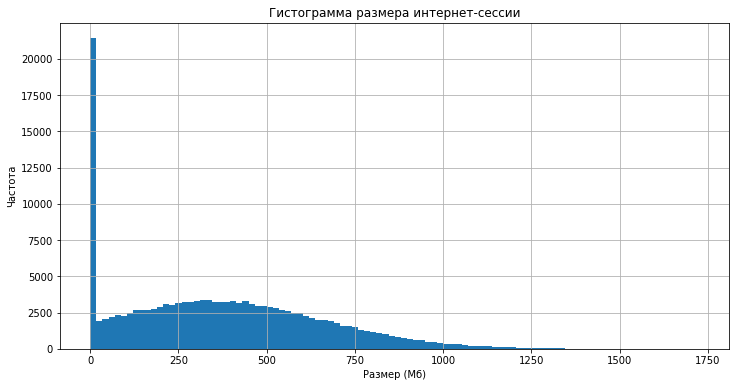

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(internet['mb_used'], bins=100)
ax.set_xlabel('Размер (Мб)')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма размера интернет-сессии')
ax.grid()
plt.show()

In [19]:
internet[internet['mb_used'] == 0]

,id,mb_used,session_date,user_id
11,1000_11,0.0,2018-08-28,1000
38,1000_38,0.0,2018-11-27,1000
46,1000_46,0.0,2018-06-30,1000
67,1000_67,0.0,2018-06-16,1000
72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499
149381,1499_142,0.0,2018-11-01,1499
149383,1499_144,0.0,2018-11-27,1499
149386,1499_147,0.0,2018-10-21,1499


In [20]:
internet_zero = internet[internet['mb_used'] == 0]

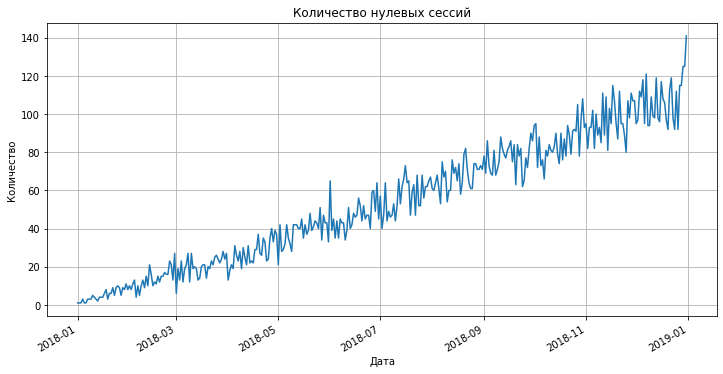

In [21]:
ax = internet_zero.groupby('session_date')['session_date'].count().plot(figsize=(12,6), grid=True, 
   title='Количество нулевых сессий')
ax.set_xlabel("Дата")
ax.set_ylabel("Количество")
plt.show()

In [22]:
internet_nonzero = internet[internet['mb_used'] > 0]

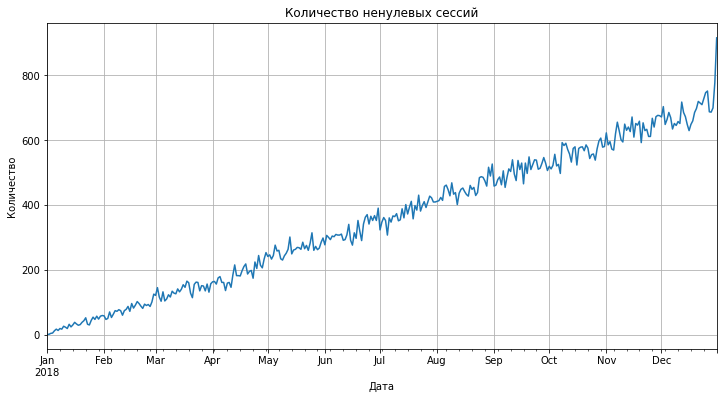

In [23]:
ax = internet_nonzero.groupby('session_date')['session_date'].count().plot(figsize=(12,6), grid=True, 
   title='Количество ненулевых сессий')
ax.set_xlabel("Дата")
ax.set_ylabel("Количество")
plt.show()

In [24]:
len(internet_zero) + len(internet_nonzero)

149396

Мы обнаружили интернет-сессии с нулевым трафиком. Мы можем видеть, что это не разовый всплеск, а вполне систематический. Видим, что в течение года количество таких сессий растёт, и растёт также как и количество сессий с ненулевым трафиком. Рост сессий можно объяснить постепенным подключением клиентов к тарифу, и просто повышением интереса к интернет сервисам для мобильных устройств. Можно предположить, что нулевые сессии - это какая-то техническая особенность регистрации трафика. Нам такие сессии не интересны. На стоимость услуг они влияния не оказывает, поэтому такие сессии можно удалить из рассмотрения.

In [25]:
internet = internet_nonzero

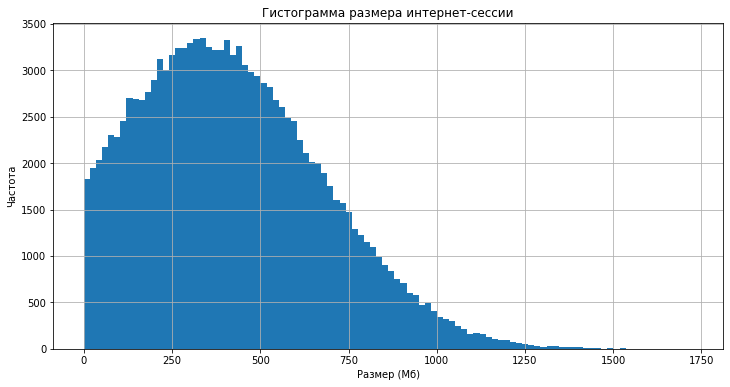

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(internet['mb_used'], bins=100)
ax.set_xlabel('Размер (Мб)')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма размера интернет-сессии')
ax.grid()
plt.show()

In [27]:
internet['mb_used'].describe()

count    129798.000000
mean        426.087210
std         255.596447
min           0.030000
25%         227.460000
50%         400.540000
75%         592.947500
max        1724.830000
Name: mb_used, dtype: float64

Проверим также, что у нас нет лишних данных для непредставленных клиентов.

In [28]:
user_ids = users['user_id'].unique()

In [29]:
internet.query('user_id not in @user_ids')['user_id'].count()

0

### Таблица calls (информация о звонках)

In [30]:
calls['call_date'].describe()

count         202607
unique           365
top       2018-12-31
freq            1435
Name: call_date, dtype: object

In [31]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

Всё то же самое можно сказать про звоники.

In [32]:
calls.duplicated().sum()

0

Общих повторений по всем столбцам нету

In [33]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

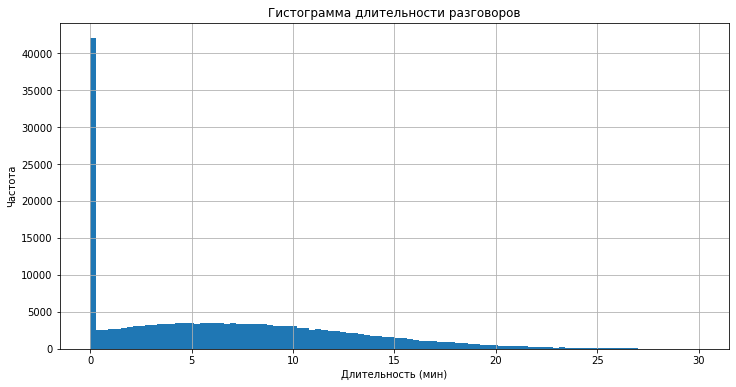

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(calls['duration'], bins=100, range=(0, 30))
ax.set_xlabel('Длительность (мин)')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма длительности разговоров')
ax.grid()
plt.show()

In [35]:
len(calls[calls['duration'] == 0])

39613

У нас явно есть пик на нуле.

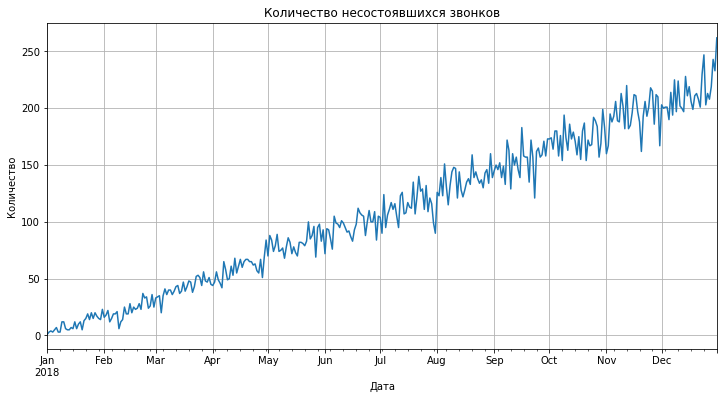

In [36]:
ax = calls[calls['duration'] == 0].groupby('call_date')['call_date'].count().plot(figsize=(12,6), grid=True, 
   title='Количество несостоявшихся звонков')
ax.set_xlabel("Дата")
ax.set_ylabel("Количество")
plt.show()

Количество несостоявшихся разговоров нулевой длительности также как и интренет-сессии растёт со временем. Похоже, такие звонки не являются какой-то аномалией. Хотя они не влияют напрямую на стоимость тарифа, можно использовать их для оценки количества звонков среди тарифов.

Удалим данные по несостоявшимся звонкам, так как они никак не влияют на выручку.

In [37]:
calls = calls[calls['duration'] != 0]

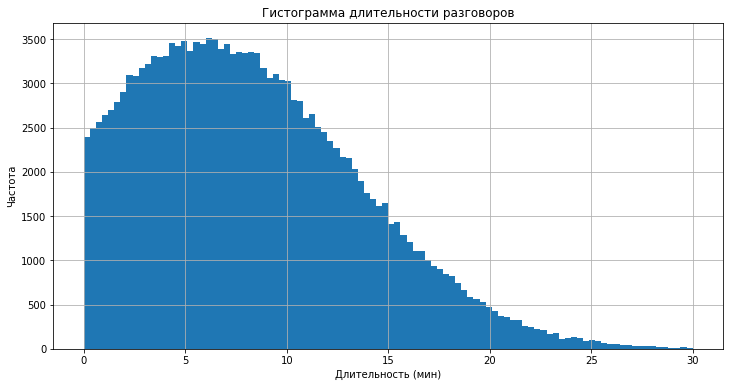

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(calls['duration'], bins=100, range=(0, 30))
ax.set_xlabel('Длительность (мин)')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма длительности разговоров')
ax.grid()
plt.show()

Проверим также, что у нас нет лишних данных для непредставленных клиентов.

In [39]:
calls.query('user_id not in @user_ids')['user_id'].count()

0

### Таблица messages (информация о сообщениях)

In [40]:
messages['message_date'].describe()

count         123036
unique           364
top       2018-12-31
freq             859
Name: message_date, dtype: object

In [41]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [42]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [43]:
messages.duplicated().sum()

0

Общих повторений по всем столбцам нету

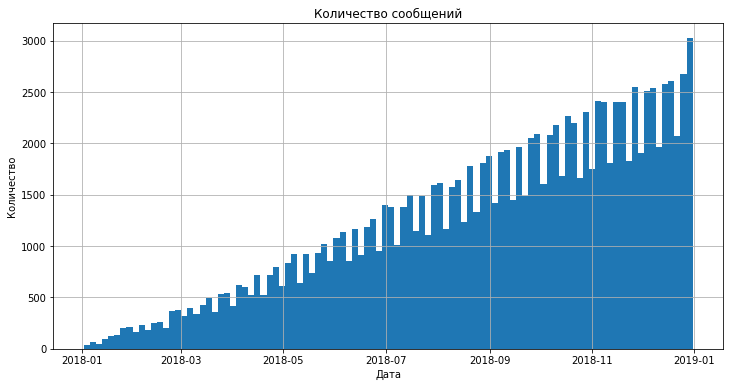

In [44]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(messages['message_date'], bins=100)
ax.set_xlabel('Дата')
ax.set_ylabel('Количество')
ax.set_title('Количество сообщений')
ax.grid()
plt.show()

In [45]:
messages.query('user_id not in @user_ids')['user_id'].count()

0

### Таблица users (информация о пользователях)

In [46]:
users['churn_date'].describe()

count             38
unique            33
top       2018-12-03
freq               2
Name: churn_date, dtype: object

In [47]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [48]:
users['reg_date'].describe()

count            500
unique           270
top       2018-05-28
freq               8
Name: reg_date, dtype: object

In [49]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [50]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [51]:
users.duplicated().sum()

0

Общих повторений по всем столбцам нету

In [52]:
users['user_id'].duplicated().sum()

0

Идентификаторы пользователей уникальные

In [53]:
users['city'].duplicated().sum()

424

In [54]:
users['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

Возможно имеет смысл объединить города по регионам. Например: Балашиху, Подольск, Химки в Московскую область и т. п.

In [55]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

In [56]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

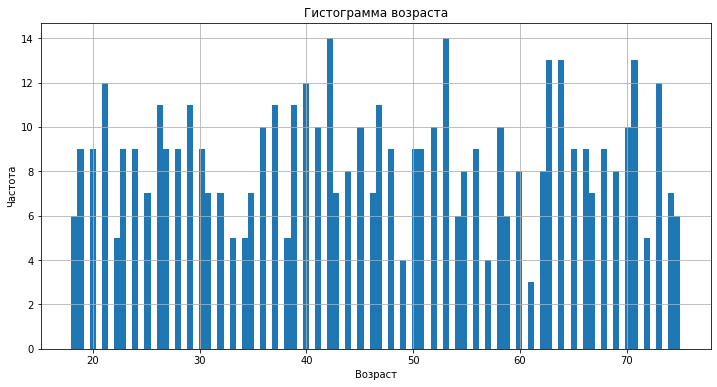

In [57]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(users['age'], bins=100)
ax.set_xlabel('Возраст')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма возраста')
ax.grid()
plt.show()

Аномалий в данных пользователей не обнаружено

### Округление данных

Округлим до целых количество минут и мегабайтов, для удобства расчётов

In [58]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [59]:
calls['duration'].head()

2     3
3    14
4     6
7    19
8    19
Name: duration, dtype: int32

In [60]:
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')

In [61]:
internet['mb_used'].head()

0     113
1    1053
2    1198
3     551
4     303
Name: mb_used, dtype: int32

### Подсчёт данных по месяцам

#### Группировка по месяцам

Добавим столбцы с месяцем и сгруппируем данные помесячно по звонкам, трафику и сообщениям.

In [62]:
internet['month'] = internet['session_date'].dt.month.astype('int')

In [63]:
internet_month = internet.pivot_table(index=['user_id', 'month'], aggfunc=({'mb_used': 'sum'}))

In [64]:
internet_month

mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581
...                ...
1498    10       20604
1499    9         1848
        10       17809
        11       17984
        12       13077

[3201 rows x 1 columns]

In [65]:
calls['month'] = calls['call_date'].dt.month.astype('int')

In [66]:
calls_month = calls.pivot_table(index=['user_id', 'month'], aggfunc=({'duration': 'sum', 'user_id': 'count'}))

In [67]:
calls_month.columns

Index(['duration', 'user_id'], dtype='object')

In [68]:
calls_month.columns = ['minutes_used', 'calls_count']

In [69]:
calls_month

minutes_used  calls_count
user_id month                           
1000    5               159           17
        6               172           28
        7               340           41
        8               408           42
        9               466           46
...                     ...          ...
1498    10              247           30
1499    9                70            8
        10              449           44
        11              612           62
        12              492           56

[3168 rows x 2 columns]

In [70]:
calls_month.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3168 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   minutes_used  3168 non-null   int32
 1   calls_count   3168 non-null   int64
dtypes: int32(1), int64(1)
memory usage: 50.5 KB


In [71]:
messages['month'] = messages['message_date'].dt.month.astype('int')

In [72]:
messages_month = messages.pivot_table(index=['user_id', 'month'], aggfunc=({'month': 'count'}))

In [73]:
messages_month.columns = ['messages_used']

In [74]:
messages_month

messages_used
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
...                      ...
1498    10                42
1499    9                 11
        10                48
        11                59
        12                66

[2717 rows x 1 columns]

#### Консолидация данных

Соединим данные о звонках, трафике и сообщениях в один датасет.

In [75]:
df = calls_month.merge(internet_month, on=['user_id', 'month'], how='outer')

In [76]:
df = df.merge(messages_month, on=['user_id', 'month'], how='outer')

In [77]:
df

minutes_used  calls_count  mb_used  messages_used
user_id month                                                   
1000    5             159.0         17.0   2256.0           22.0
        6             172.0         28.0  23257.0           60.0
        7             340.0         41.0  14016.0           75.0
        8             408.0         42.0  14070.0           81.0
        9             466.0         46.0  14581.0           57.0
...                     ...          ...      ...            ...
1489    8               NaN          NaN  11066.0           17.0
        9               NaN          NaN  17232.0           32.0
        10              NaN          NaN  19588.0           21.0
        11              NaN          NaN  17516.0           20.0
        12              NaN          NaN  17341.0           35.0

[3214 rows x 4 columns]

Добавим данные о тарифах и пользователях.

In [78]:
df = df.reset_index()

In [79]:
df = df.merge(users, on='user_id', how='left')

In [80]:
df.columns

Index(['user_id', 'month', 'minutes_used', 'calls_count', 'mb_used',
       'messages_used', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

In [81]:
df.columns = ['user_id', 'month', 'minutes_used', 'calls_count', 'mb_used',
       'messages_used', 'age', 'churn_date', 'city', 'first_name',
       'last_name', 'reg_date', 'tariff_name']

In [82]:
df = df.merge(tariffs, on='tariff_name', how='left')

In [83]:
df

,user_id,month,minutes_used,calls_count,mb_used,messages_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,17.0,2256.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,28.0,23257.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,41.0,14016.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,42.0,14070.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,46.0,14581.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,NaN,NaN,11066.0,17.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3210,1489,9,NaN,NaN,17232.0,32.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3211,1489,10,NaN,NaN,19588.0,21.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,1489,11,NaN,NaN,17516.0,20.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   minutes_used           3168 non-null   float64       
 3   calls_count            3168 non-null   float64       
 4   mb_used                3201 non-null   float64       
 5   messages_used          2717 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff_name            3214 non-null   object        
 13  mes

После объединения видим, что появились нулевые значения в полях minutes_used, calls_count, messages_used, mb_used. Здесь вполне очевидно, что пользователи пользовались лишь интернетом, вполне нормальное явление, возможно тариф использовался в модеме, либо наоборот не пользовались интренетом. Заполним их нулями.

In [85]:
for row_name in ['minutes_used', 'calls_count', 'messages_used', 'mb_used']:
    df[row_name] = df[row_name].fillna(0)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   minutes_used           3214 non-null   float64       
 3   calls_count            3214 non-null   float64       
 4   mb_used                3214 non-null   float64       
 5   messages_used          3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff_name            3214 non-null   object        
 13  mes

#### Подсчёт выручки

In [87]:
def set_income(row):
    tariff = row['tariff_name']
    minutes_excess = row['minutes_used'] - row['minutes_included']
    if minutes_excess < 0:
        minutes_excess = 0
    mb_excess = row['mb_used'] - row['mb_per_month_included']
    if mb_excess < 0:
        mb_excess = 0
    messages_excess = row['messages_used'] - row['messages_included']
    if messages_excess < 0:
        messages_excess = 0
    income = row['rub_monthly_fee'] + row['rub_per_minute'] * minutes_excess + row['rub_per_gb'] * mb_excess / 1024 + row['rub_per_gb'] * messages_excess
    return income


In [88]:
df['income'] = df.apply(set_income, axis=1)

In [89]:
df

,user_id,month,minutes_used,calls_count,mb_used,messages_used,age,churn_date,city,first_name,...,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
0,1000,5,159.0,17.0,2256.0,22.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.000000
1,1000,6,172.0,28.0,23257.0,60.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.000000
2,1000,7,340.0,41.0,14016.0,75.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.000000
3,1000,8,408.0,42.0,14070.0,81.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.000000
4,1000,9,466.0,46.0,14581.0,57.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,11066.0,17.0,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,550.000000
3210,1489,9,0.0,0.0,17232.0,32.0,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,915.625000
3211,1489,10,0.0,0.0,19588.0,21.0,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,1375.781250
3212,1489,11,0.0,0.0,17516.0,20.0,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,50,15360,500,550,200,3,3,971.093750


Для анализа осталось сделать последний шаг. У нас есть периоды, когда пользователи пользовались тарифом не целый месяц (подключились или отключились в течение месяца). Для чистоты исследования нужно исключить эти месяцы для всех клиентов, поскольку мы не знаем, как тарифицируются такие периоды. Удалим месячные данные, если пользователь не подключился 1го числа или ушёл из тарифа не в последний день месяца.

#### Удаление данных по неполным месяцам пользования

In [90]:
len(df[(df['month'] == df['reg_date'].dt.month) & (df['reg_date'].dt.day != 1)])

481

In [91]:
df = df.drop(df[(df['month'] == df['reg_date'].dt.month) & (df['reg_date'].dt.day != 1)].index)

Удалили данные месяцев подключения.

In [92]:
len(df)

2733

In [93]:
len(df[(df['month'] == df['churn_date'].dt.month) & (df['reg_date'].dt.month == (df['reg_date'] + pd.to_timedelta(1, unit="D")).dt.month)])

35

In [94]:
df = df.drop(df[(df['month'] == df['churn_date'].dt.month) & (df['reg_date'].dt.month == (df['reg_date'] + pd.to_timedelta(1, unit="D")).dt.month)].index)

In [95]:
len(df)

2698

## Анализ данных

Разделим данные по тарифам

In [96]:
df.columns

Index(['user_id', 'month', 'minutes_used', 'calls_count', 'mb_used',
       'messages_used', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name', 'messages_included', 'mb_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute', 'income'],
      dtype='object')

Посчитаем **средние величины** для тарифов.

In [97]:
df.pivot_table(index=['tariff_name'], aggfunc=({'user_id': 'count', 
                                                'minutes_used': 'mean',
                                                'calls_count': 'mean', 
                                                'mb_used': 'mean', 
                                                'messages_used': 'mean', 
                                                'age': 'mean', 
                                                'income': 'mean'}))

,age,calls_count,income,mb_used,messages_used,minutes_used,user_id
tariff_name,,,,,,,
smart,46.620246,50.875736,2645.188747,17554.122657,36.111409,452.534012,1867
ultra,46.789410,64.528279,2079.447414,21153.572804,53.199759,573.539110,831


На тарифе Ультра в среднем пользователи больше пользуются интернетом, разговорами и сообщениями. Но при этом средняя выручка от тарифа меньше. Выборка по тарифам не симметричная, данных по тарифу Смарт больше. Что интересно, средний возраст пользователей практически совпадает.

###  Использованные минуты разговора

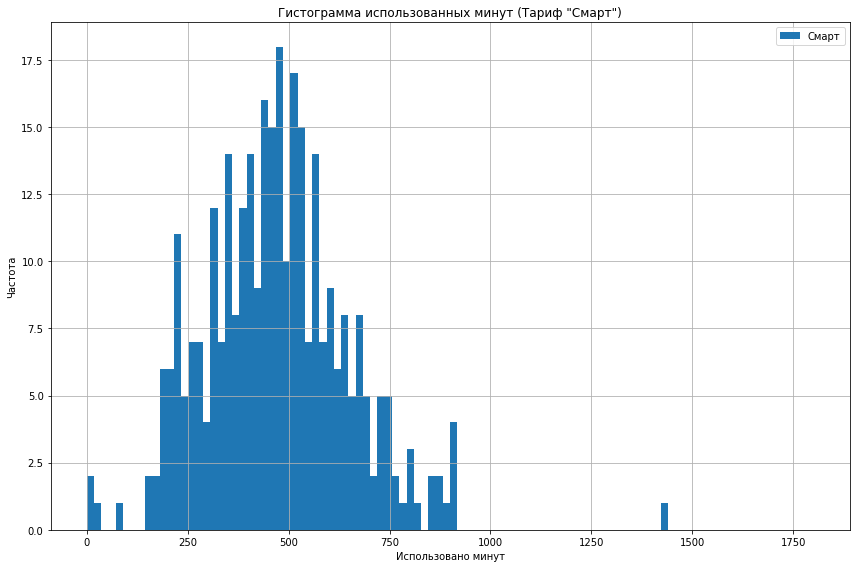

In [98]:
df_minutes_smart = df[df['tariff_name']=='smart'].pivot_table(index=['user_id'], aggfunc=({'minutes_used': 'mean'}))['minutes_used']

fig, ax = plt.subplots(figsize=(12,8))
ax.hist(df_minutes_smart, bins=100, range=(0, 1800), label='Смарт')
ax.set_xlabel('Использовано минут')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма использованных минут (Тариф "Смарт")')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

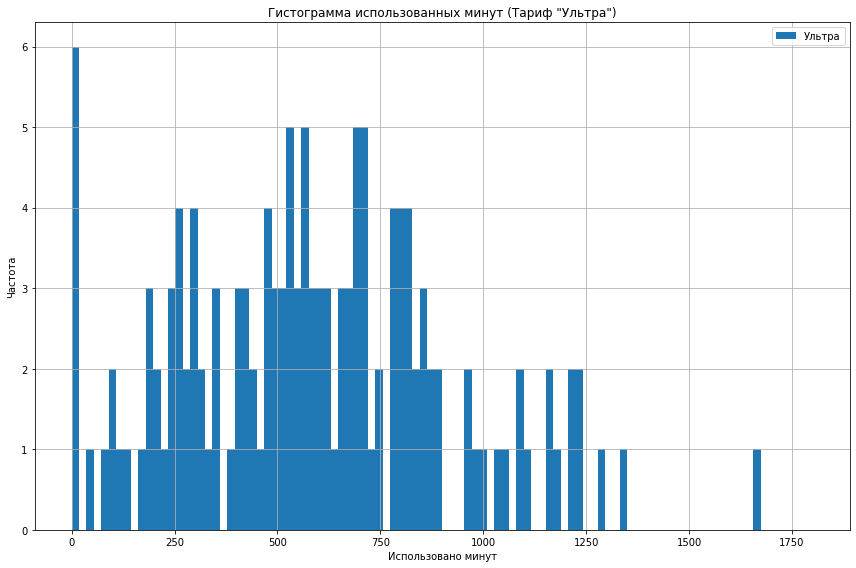

In [99]:
df_minutes_ultra = df[df['tariff_name']=='ultra'].pivot_table(index=['user_id'], aggfunc=({'minutes_used': 'mean'}))['minutes_used']

fig, ax = plt.subplots(figsize=(12,8))

ax.hist(df_minutes_ultra, bins=100, range=(0, 1800), label='Ультра')
ax.set_xlabel('Использовано минут')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма использованных минут (Тариф "Ультра")')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

Рассчитаем **дисперсию** по значению *Использованные минуты разговора*.

In [100]:
df.groupby('tariff_name')['minutes_used'].var()

tariff_name
smart    31106.069984
ultra    94811.248770
Name: minutes_used, dtype: float64

Рассчитаем **стандартное отклонение** по значению *Использованные минуты разговора*.

In [101]:
df.groupby('tariff_name')['minutes_used'].std()

tariff_name
smart    176.369130
ultra    307.914353
Name: minutes_used, dtype: float64

In [102]:
df.groupby('tariff_name')['minutes_used'].agg(['mean','median'])

,mean,median
tariff_name,,
smart,452.534012,454.0
ultra,573.539110,565.0


Если не брать в расчёт выбросы при нулевых значениях, то я бы назвал диаграммы распределения для данных выборок близкими к нормальному и симметричными. Для тарифа Ультра можно отметить более широкий разброс значений, что подтверждает и большее стандартное отклонение.

Такое поведение пользователей, возможно, говорит о том, что те, кто пользуется тарифом Смарт, точно знают, сколько звонков им требуется в месяц, либо пытаются уложиться в лимит тарифа. Среднее (453) очень близко к лимиту (500). В то время как пользователи Ультра пользуются минутами более "расслаблено". 

Очевидно, что половина пользователей Смарта не укладывается в лимиты.

###  Количество сообщений

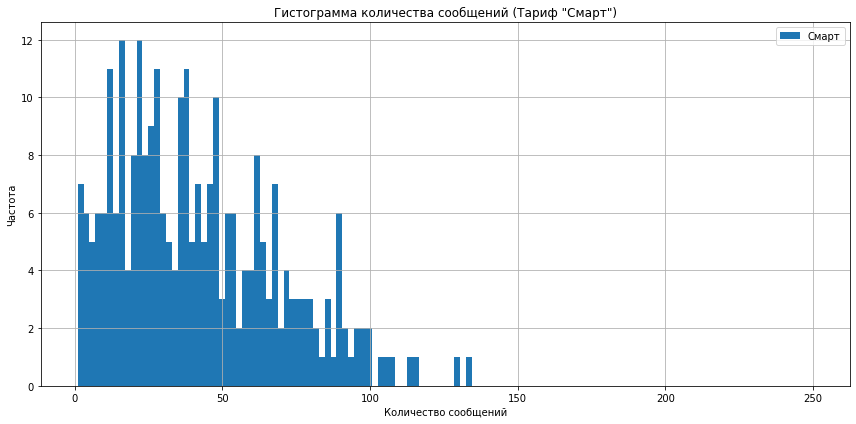

In [103]:
df_messages_smart = df[df['tariff_name']=='smart'].pivot_table(index=['user_id'], aggfunc=({'messages_used': 'mean'}))['messages_used']

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df_messages_smart, bins=125, range=(1, 250), label='Смарт')
ax.set_xlabel('Количество сообщений')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма количества сообщений (Тариф "Смарт")')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

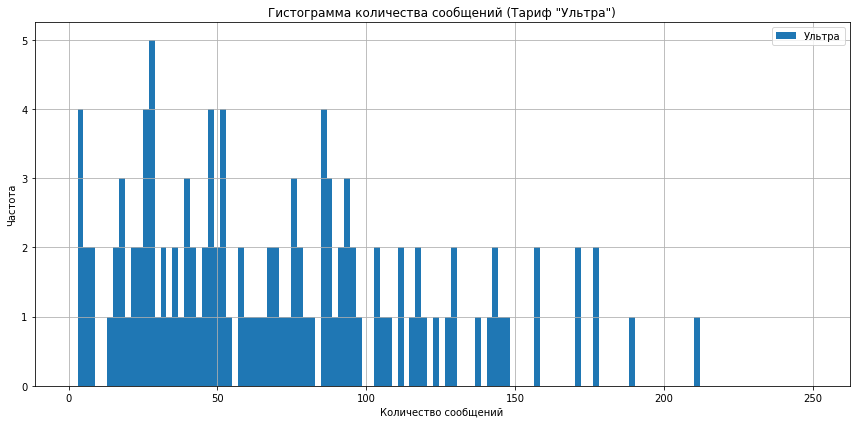

In [104]:
df_messages_ultra = df[df['tariff_name']=='ultra'].pivot_table(index=['user_id'], aggfunc=({'messages_used': 'mean'}))['messages_used']

fig, ax = plt.subplots(figsize=(12,6))

ax.hist(df_messages_ultra, bins=125, range=(1, 250), label='Ультра')
ax.set_xlabel('Количество сообщений')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма количества сообщений (Тариф "Ультра")')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

Рассчитаем **дисперсию** по значению *Количество сообщений*.

In [105]:
df.groupby('tariff_name')['messages_used'].var()

tariff_name
smart     825.309125
ultra    2385.246795
Name: messages_used, dtype: float64

Рассчитаем **стандартное отклонение** по значению *Количество сообщений*.

In [106]:
df.groupby('tariff_name')['messages_used'].std()

tariff_name
smart    28.728194
ultra    48.838988
Name: messages_used, dtype: float64

In [107]:
df.groupby('tariff_name')['messages_used'].agg(['mean','median'])

,mean,median
tariff_name,,
smart,36.111409,31.0
ultra,53.199759,43.0


Диаграммы распределения для данных выборок близки к нормальному (если не учитывать выбросы на нулевых значениях), но скошены вправо, также это видно по разнице медианы и среднего. Для тарифа Ультра можно отметить более широкий разброс значений, что подтверждает и большее стандартное отклонение.

По сообщениям наблюдается похожее поведение, как и для звонков: стремление уложиться в лимит. Хотя и для Ультры среднее (53) не сильно превышает лимит Смарта (50).

###  Объём интернет-трафика

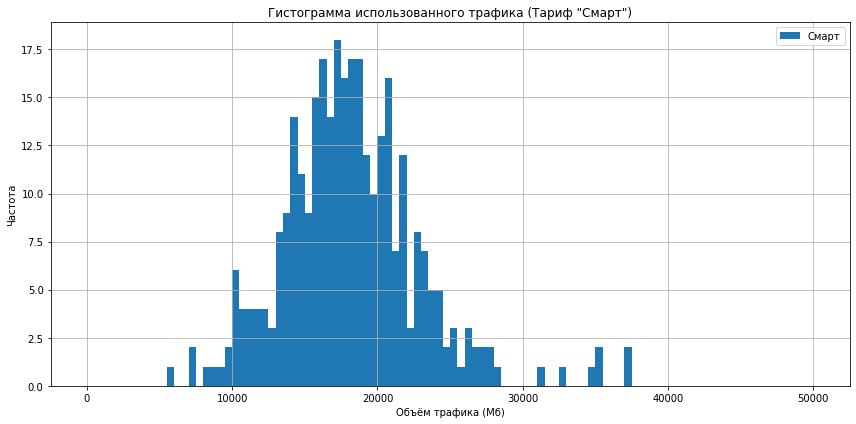

In [108]:
df_mb_smart = df[df['tariff_name']=='smart'].pivot_table(index=['user_id'], aggfunc=({'mb_used': 'mean'}))['mb_used']

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df_mb_smart, bins=100, range=(0, 50000), label='Смарт')
ax.set_xlabel('Объём трафика (Мб)')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма использованного трафика (Тариф "Смарт")')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

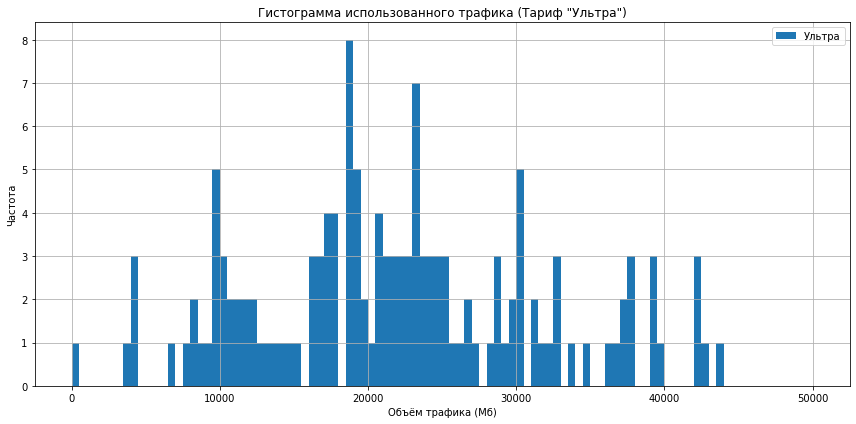

In [109]:
df_mb_ultra = df[df['tariff_name']=='ultra'].pivot_table(index=['user_id'], aggfunc=({'mb_used': 'mean'}))['mb_used']

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df_mb_ultra, bins=100, range=(0, 50000), label='Ультра')
ax.set_xlabel('Объём трафика (Мб)')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма использованного трафика (Тариф "Ультра")')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

Рассчитаем **дисперсию** по значению *Объём интернет-трафика*.

In [110]:
df.groupby('tariff_name')['mb_used'].var()

tariff_name
smart    2.414500e+07
ultra    8.977563e+07
Name: mb_used, dtype: float64

Рассчитаем **стандартное отклонение** по значению *Объём интернет-трафика*.

In [111]:
df.groupby('tariff_name')['mb_used'].std()

tariff_name
smart    4913.756416
ultra    9475.000505
Name: mb_used, dtype: float64

In [112]:
df.groupby('tariff_name')['mb_used'].agg(['mean','median'])

,mean,median
tariff_name,,
smart,17554.122657,17329.0
ultra,21153.572804,20700.0


Диаграммы распределения для данных выборок близки к нормальному и симметричны, также и средние слабо отличаются от медианных. Для тарифа Ультра можно отметить более широкий разброс значений, что подтверждает и стандартное отклонение.

Алалогичное поведение пользователей и по использованию интернета. Смартовцы стремятся уложиться в лимит (15 Гб), что у них часто не получается (~17 Гб) и больше половины вылезают из лимитов, тогда как Ультровцы ни в чём себе не отказывают и большая часть полностью удовлетворены лимитом (30 Гб), если оценивать по стандартному отклонению, то это как минимум 84% всех пользователей.

###  Выручка 

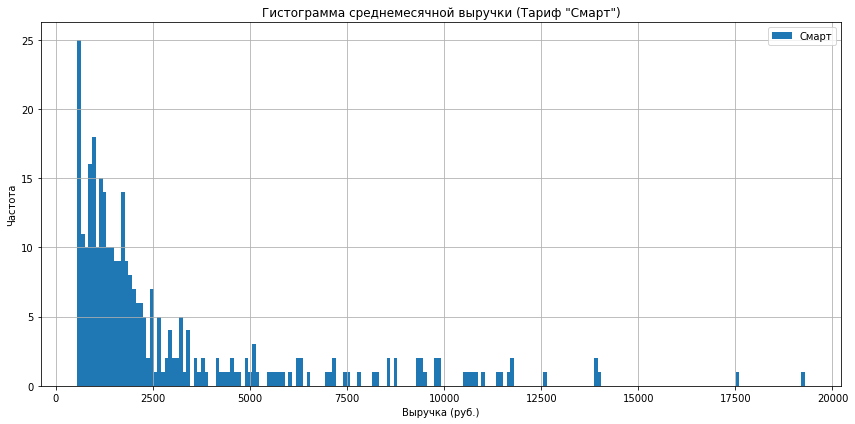

In [113]:
df_income_smart = df[df['tariff_name']=='smart'].pivot_table(index=['user_id'], aggfunc=({'income': 'mean'}))['income']

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df_income_smart, bins=200, label='Смарт')
ax.set_xlabel('Выручка (руб.)')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма среднемесячной выручки (Тариф "Смарт")')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

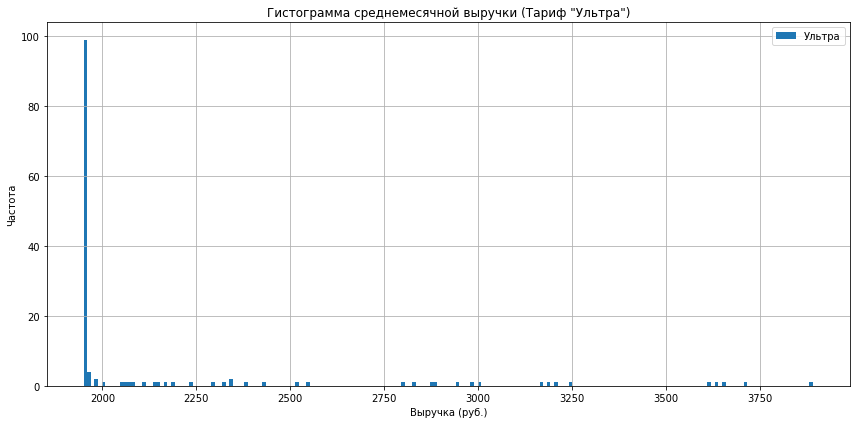

In [114]:
df_income_ultra = df[df['tariff_name']=='ultra'].pivot_table(index=['user_id'], aggfunc=({'income': 'mean'}))['income']

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df_income_ultra, bins=200, label='Ультра')
ax.set_xlabel('Выручка (руб.)')
ax.set_ylabel('Частота')

ax.set_title('Гистограмма среднемесячной выручки (Тариф "Ультра")')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [115]:
df.groupby('tariff_name')['income'].var()

tariff_name
smart    8.996351e+06
ultra    1.474772e+05
Name: income, dtype: float64

In [116]:
df.groupby('tariff_name')['income'].agg(['mean','median'])

,mean,median
tariff_name,,
smart,2645.188747,1538.085938
ultra,2079.447414,1950.000000


Распределения выручки не похожи на нормальное, и разброс для тарифа Смарт на порядок выше, чем у Ультры. 

###  Кому выгодно сменить тариф?

Сделаем дополнительный анализ. Найдём количество пользователей, которые пользуются тарифом Смарт, платят больше, чем в Ультре и укладываются в лимиты Ультры. То есть это пользователи, которым выгоднее сменить тариф.

In [117]:
len(df[(df['tariff_name'] == 'smart') 
   & (df['income'] > 1950) 
   & (df['mb_used'] <= 30*1024) 
   & (df['minutes_used'] <= 3000) 
   & (df['messages_used'] <= 1000)]['user_id'].unique())

207

In [118]:
len(df[(df['tariff_name'] == 'smart')]['user_id'].unique())

319

In [119]:
207 / 319 * 100

64.89028213166145

В нашей выборке для 65% пользователей тарифа "Смарт" абсолютно выгодно поменять тариф.

In [120]:
len(df[(df['tariff_name'] == 'ultra') 
   & (df['mb_used'] <= 15*1024) 
   & (df['minutes_used'] <= 500) 
   & (df['messages_used'] <= 50)]['user_id'].unique())

14

In [121]:
len(df[(df['tariff_name'] == 'ultra')]['user_id'].unique())

140

In [122]:
14 / 140 * 100

10.0

Для 10% пользователей тарифа "Ультра" из выборки абсолютно выгодно поменять тариф.

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформируем две генеральных совокупности.

In [123]:
income_smart = df[df['tariff_name']=='smart']['income']

In [124]:
income_ultra = df[df['tariff_name']=='ultra']['income']

Поскольку мы имеем две совершенно разные группы пользователей, наши генеральные совокупности независимые. Судя по заметной разнице в характере распределений, учтём различие их дисперсий. 

Предположим, что их **средние значения равны (нулевая гипотеза H₀)**, альтернативная гипотеза, что средние значения отличаются. Применим t-тестирование.

Возьмём критический уровень статистической значимости 5%

In [125]:
alpha = 0.05

In [126]:
results = st.ttest_ind(income_smart, income_ultra, equal_var = False)

p-значение

In [127]:
results.pvalue

2.0229987921367948e-15

In [128]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Отвергаем нулевую гипотезу


Мы вынуждены отвергнуть нашу гипотезу в пользу альтернативной (**средние значения не равны**).

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформируем две генеральных совокупности.

In [129]:
income_moscow = df[df['city']=='Москва']['income']

In [130]:
income_others = df[df['city']!='Москва']['income']

In [131]:
income_moscow.var()

3542852.0628283545

In [132]:
income_others.var()

6959256.853735878

Поскольку мы имеем две непересекающиеся группы пользователей, наши генеральные совокупности независимые с разными дисперсиями.

Предположим, что их **средние значения равны (нулевая гипотеза H₀)**, альтернативная гипотеза, что средние значения отличаются. Применим t-тестирование.

In [133]:
from scipy import stats as st

Возьмём критический уровень статистической значимости 5%

In [134]:
alpha = 0.05

In [135]:
results = st.ttest_ind(income_moscow, income_others, equal_var = False)

p-значение

In [136]:
results.pvalue

4.439382453594543e-05

In [137]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

Отвергаем нулевую гипотезу


Скорее всего **выручки не отличаются**.

### Сравнение со средним по всей выборке

In [138]:
income_average = df['income'].mean().round()
income_average

2471.0

Из имеющейся выборки среднее значение выручки - **2471**. Проверим гипотезу, что **среднее значение выручки для Ультра останется таким же (нулевая гипотеза)**. И **альтернативная - среднее значение больше**. 

H₀: Х = 2471 H₁: Х > 2471 

Возьмём критический уровень статистической значимости 5%.

In [139]:
interested_value = income_average

alpha = 0.05

results = st.ttest_1samp(income_ultra, interested_value)

print('p-значение:', results.pvalue / 2)

if ((results.pvalue / 2 < alpha) and (income_ultra.mean() > interested_value)):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.217621199202918e-131
Не получилось отвергнуть нулевую гипотезу


Для тарифа Ультра подтвердилась гипотеза о равенстве среднему значению. Проверим тоже самое для тарифа Смарт

Из имеющейся выборки среднее значение выручки - **2471**. Проверим, что **среднее значение выручки для Смарта равно среднему по всей выборке (нулевая гипотеза)**. И **альтернативная - среднее значение больше**. 

H₀: Х = 2471 H₁: Х > 2471 

Возьмём критический уровень статистической значимости 5%.

In [140]:
interested_value = income_average

alpha = 0.05

results = st.ttest_1samp(income_smart, interested_value)

print('p-значение:', results.pvalue / 2)

if ((results.pvalue / 2 < alpha) and (income_smart.mean() > interested_value)):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.006089955483487135
Отвергаем нулевую гипотезу


Побеждает альтернативная гипотеза, о том, что среднее значение превысит среднее по всей выборке.

## Общий вывод

Исходя из аализа выборки, пользователи тарифа Ультра в среднем используют приблизительно в 1,3 раза больше звонков, минут, сообщений и мегабайт трафика в сравнении с пользователями тарифа Смарт, но поразительным образом платят в среднем за это во столько же раз меньше.

**Среднемесячная выручка в Москве и регионах одинаковая**

Исследование не выявило разницы выручки у пользователей Москвы и других регионов. Гипотеза о равенстве средних показателей подтвеждается с критическим уровнем статистической значимости 5%.

**Среднемесячная выручка от пользователей тарифа «Смарт» больше**


Средняя выручка для тарифа "Смарт": 2645 руб.
Средняя выручка для тарифа "Ультра": 2079 руб.

Кроме того, анализ распределений выборок дал следующие результаты:

Гипотеза о равенстве средних показателей выручки для тарифов "Смарт" и "Ультра" не подтвердилась, а гипотеза о превышении среднего значения 2471 рубль подтвердилась для тарифа "Смарт" с критическим уровнем статистической значимости 5%.



Можно утверждать, что **тариф "Смарт" будет выгоден оператору** в течение некоторого времени.

Мы увидели в предварительном анализе данных, что больше половины пользователей тарифа Смарт превышают лимиты тарифа. Кроме того, для 65% пользователей тарифа Смарт, исходя из статистики использования, выгоднее использовать тариф Ультра. Доля таких же в Ультре не менее 10%, которые могут оптимизировать расходы, перейдя на Смарт.

Это показывает, что **возможна заметная миграция пользователей в сторону Ультры с общим уменьшением выручки**, если пользователи начнут анализировать свои расходы.